In [8]:
import pandas as pd
import numpy as np
import math
import copy
import QSTK.qstkutil.qsdateutil as du
import datetime as dt
import QSTK.qstkutil.DataAccess as da
import QSTK.qstkutil.tsutil as tsu
import QSTK.qstkstudy.EventProfiler as ep
import matplotlib.pyplot as plt
import bollinger
import performance

symbol_txt_file = 'sp5002012'


dt_start = dt.datetime(2008, 2, 25)
dt_end = dt.datetime(2009, 12, 31)
ldt_timestamps = du.getNYSEdays(dt_start, dt_end, dt.timedelta(hours=16))

dataobj = da.DataAccess('Yahoo')
ls_symbols = dataobj.get_symbols_from_list(symbol_txt_file)

ls_symbols.append('SPY')

ls_keys = ['open', 'high', 'low', 'close', 'volume', 'actual_close']
ldf_data = dataobj.get_data(ldt_timestamps, ls_symbols, ls_keys)
d_data = dict(zip(ls_keys, ldf_data))

for s_key in ls_keys:
    d_data[s_key] = d_data[s_key].fillna(method='ffill')
    d_data[s_key] = d_data[s_key].fillna(method='bfill')
    d_data[s_key] = d_data[s_key].fillna(1.0)

df_close = d_data['actual_close']



In [9]:
lookback = 20
unit_of_std = 1.0
df_indicator = df_close.copy()
for sym in ls_symbols:
    df_indicator[sym] = bollinger.bollinger_indicator(df_close[sym],lookback,unit_of_std)

In [10]:
order_filename = 'orders.csv'
orders = pd.DataFrame({'year': [], 'month': [],'date':[],'sym':[],'type':[],'shares':[],'crap':[]})
orders = orders[['year','month','date','sym','type','shares','crap']]
num_trades = 0
orders.loc[num_trades] = [str(ldt_timestamps[0].year),str(ldt_timestamps[0].month),str(ldt_timestamps[0].day),
                          ls_symbols[0],'Buy','0','0']
num_trades += 1
for i in range(lookback-1, len(ldt_timestamps)):    
    for s_sym in ls_symbols:
        # Calculating the returns for this timestamp
        # Event is found if the symbol price is greater than $5 yesterday but less than $5 today
        indicator_today = df_indicator[s_sym].ix[ldt_timestamps[i]]
        indicator_yest = df_indicator[s_sym].ix[ldt_timestamps[i-1]]
        indicator_today_SPY = df_indicator['SPY'].ix[ldt_timestamps[i]]
        if indicator_today <=-2.0 and indicator_yest >= -2.0 and indicator_today_SPY>=1.0:
            date = ldt_timestamps[i]
            date_Sell = ldt_timestamps[min(i+5,len(ldt_timestamps)-1)]
            orders.loc[num_trades] = [str(date.year),str(date.month),str(date.day),s_sym,'Buy','100','0']
            orders.loc[num_trades+1] = [str(date_Sell.year),str(date_Sell.month),str(date_Sell.day),s_sym,'Sell','100','0']
            num_trades = num_trades + 2
            
orders.loc[num_trades] = [str(ldt_timestamps[-1].year),str(ldt_timestamps[-1].month),str(ldt_timestamps[-1].day),
                          ls_symbols[0],'Buy','0','0']


/Users/andy/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if sys.path[0] == '':
/Users/andy/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


In [11]:
orders.to_csv(order_filename,header=False,index=False)

Our portfolio:
('mean return:', 0.00019867132407117634)
('std return:', 0.0042428055925627563)
('sharpe ratio', 0.74333113502109371)
('cumulative return', 1.0928499999999988)

Market:
('mean return:', -7.4914475637101409e-05)
('std return:', 0.022450468217593618)
('sharpe ratio', -0.052971297581914469)
('cumulative return', 0.85848905925570929)


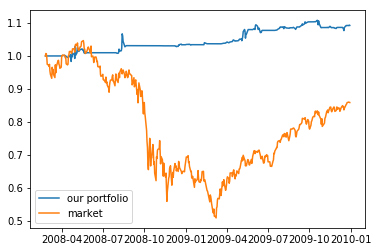

In [12]:
result = performance.performance(order_filename,'SPY',100000)
result.draw()